In [ ]:
import pandas as pd

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df=pd.read_csv('/content/spam.csv',encoding='latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [ ]:
df = df.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
df.columns = ["label", "message"]
df['label_num']=df['label'].map({
    'ham':0,
    'spam':1
})
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)
df['preprocessed_txt'] = df['message'].apply(preprocess)
df.head()

,label,message,label_num,preprocessed_txt
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think go usf live


In [ ]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
stop_words = set(stopwords.words('english'))
df['tokenized_message'] = df['preprocessed_txt'].apply(lambda x: [word for word in word_tokenize(x) if word.isalpha() and word not in stop_words])

In [ ]:
df.head()

,label,message,label_num,preprocessed_txt,tokenized_message
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...,"[jurong, point, crazy, available, bugis, n, gr..."
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni,"[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win FA Cup final tkts 2...,"[free, entry, wkly, comp, win, FA, Cup, final,..."
3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c,"[u, dun, early, hor, u, c]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think go usf live,"[nah, think, go, usf, live]"


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['message'])


In [ ]:
sentences = [text.split() for text in df['message']]
word2vec_model = Word2Vec(sentences, window=5, min_count=1, workers=4)

In [ ]:
word_embeddings = []
for text in sentences:
    embeddings = []
    for word in text:
        if word in word2vec_model.wv:
            embeddings.append(word2vec_model.wv[word])
    if embeddings:
        word_embeddings.append(sum(embeddings) / len(embeddings))
    else:
        word_embeddings.append([0] * 100)


In [ ]:
len(word_embeddings)

5572

In [ ]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(word_embeddings)

In [ ]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans.fit(reduced_embeddings)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

In [ ]:
df['cluster']=kmeans.labels_

In [ ]:
cluster_labels=kmeans.labels_

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_avg = silhouette_score(reduced_embeddings, cluster_labels)

In [ ]:
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5528715580172545


In [ ]:
df.head()

,label,message,label_num,preprocessed_txt,tokenized_message,cluster
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...,"[jurong, point, crazy, available, bugis, n, gr...",0
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni,"[ok, lar, joke, wif, u, oni]",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win FA Cup final tkts 2...,"[free, entry, wkly, comp, win, FA, Cup, final,...",0
3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c,"[u, dun, early, hor, u, c]",1
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think go usf live,"[nah, think, go, usf, live]",1


<ipython-input-24-29abae6fd466>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_embeddings[ham_indices, 0], reduced_embeddings[ham_indices, 1], label='Ham', cmap='viridis', s=5)
<ipython-input-24-29abae6fd466>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_embeddings[spam_indices, 0], reduced_embeddings[spam_indices, 1], label='Spam', cmap='viridis', s=5)


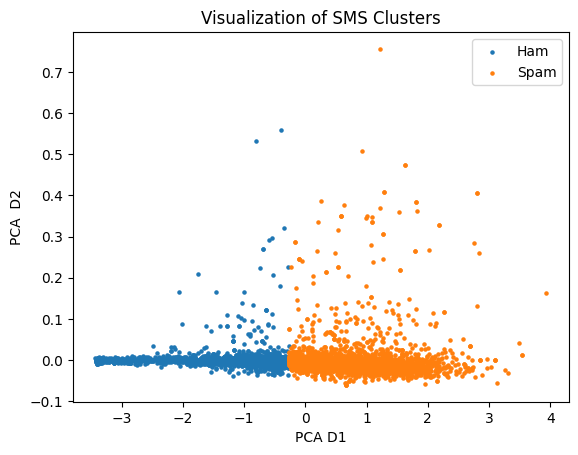

In [ ]:
ham_indices = df[df['cluster'] == 0].index
spam_indices = df[df['cluster'] == 1].index


plt.scatter(reduced_embeddings[ham_indices, 0], reduced_embeddings[ham_indices, 1], label='Ham', cmap='viridis', s=5)
plt.scatter(reduced_embeddings[spam_indices, 0], reduced_embeddings[spam_indices, 1], label='Spam', cmap='viridis', s=5)

plt.title('Visualization of SMS Clusters')
plt.legend()
plt.xlabel('PCA D1')
plt.ylabel('PCA  D2')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,classification_report

accuracy=accuracy_score(df['label_num'],df['cluster'])
report=classification_report(df['label_num'], df['cluster'])

print(f'Accuracy: {accuracy}\nClassification Report:\n{report}')



Accuracy: 0.35175879396984927
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.33      0.47      4825
           1       0.10      0.48      0.17       747

    accuracy                           0.35      5572
   macro avg       0.45      0.41      0.32      5572
weighted avg       0.71      0.35      0.43      5572



In [ ]:
word2vec_model = Word2Vec(sentences=df['tokenized_message'], window=5, min_count=1, workers=4)

In [ ]:
len(sentences)

5572

In [ ]:
sentences[0]

['Go',
 'until',
 'jurong',
 'point,',
 'crazy..',
 'Available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet...',
 'Cine',
 'there',
 'got',
 'amore',
 'wat...']

In [ ]:
word2vec_model.wv.index_to_key

['u',
 'ur',
 'go',
 'come',
 'gt',
 'lt',
 'know',
 'ok',
 'send',
 'good',
 'get',
 'like',
 'want',
 'free',
 'day',
 'time',
 'love',
 'tell',
 'text',
 'think',
 'need',
 'txt',
 'lor',
 'home',
 'today',
 'sorry',
 'r',
 'U',
 'da',
 'n',
 'stop',
 'week',
 'later',
 'reply',
 'work',
 'phone',
 'ask',
 'say',
 'mobile',
 'message',
 'wait',
 'win',
 'pls',
 'thing',
 'night',
 'hi',
 'try',
 'miss',
 'leave',
 'hope',
 'claim',
 'great',
 'oh',
 'meet',
 'number',
 'Ì',
 'feel',
 'min',
 'friend',
 'thank',
 'way',
 'hey',
 'new',
 'find',
 'late',
 'right',
 'let',
 'dear',
 'tomorrow',
 'yes',
 'yeah',
 'amp',
 'pick',
 'cash',
 'msg',
 'e',
 'wat',
 'sleep',
 'c',
 'wan',
 'buy',
 'call',
 'prize',
 'contact',
 'cos',
 'life',
 'look',
 'happy',
 'sure',
 'tone',
 'lol',
 'care',
 'watch',
 'wish',
 'start',
 'morning',
 'babe',
 'service',
 'place',
 'award',
 'b',
 'soon',
 'finish',
 'end',
 'year',
 'mean',
 'guy',
 'take',
 'word',
 'tonight',
 'k',
 'money',
 'talk',
 '

In [ ]:
word2vec_model.wv.most_similar('free')

[('txt', 0.9996980428695679),
 ('text', 0.9996654987335205),
 ('reply', 0.9996256232261658),
 ('mobile', 0.9996235370635986),
 ('ur', 0.9995986819267273),
 ('week', 0.9995286464691162),
 ('stop', 0.9994834661483765),
 ('send', 0.9994721412658691),
 ('need', 0.9994350075721741),
 ('start', 0.9994263052940369)]

In [ ]:
word2vec_model.wv.most_similar('available')

[('home', 0.9928432703018188),
 ('yes', 0.9928189516067505),
 ('time', 0.9927846193313599),
 ('day', 0.992771565914154),
 ('way', 0.9927170276641846),
 ('fine', 0.9927130937576294),
 ('min', 0.9926618337631226),
 ('n', 0.9926266670227051),
 ('money', 0.9926260709762573),
 ('reply', 0.9926108121871948)]

In [ ]:
import numpy as np
def document_vector(word2vec_model, doc):
    vectors = [word2vec_model.wv[word] for word in doc if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else None


In [ ]:
df['word2vec_vector'] = df['tokenized_message'].apply(lambda x: document_vector(word2vec_model, x))


In [ ]:
df.head()

,label,message,label_num,preprocessed_txt,tokenized_message,cluster,word2vec_vector
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...,"[jurong, point, crazy, available, bugis, n, gr...",0,"[-0.058850966, 0.10611965, 0.05101615, -0.0033..."
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni,"[ok, lar, joke, wif, u, oni]",0,"[-0.071789816, 0.12025947, 0.059862807, 0.0065..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win FA Cup final tkts 2...,"[free, entry, wkly, comp, win, FA, Cup, final,...",0,"[-0.06907025, 0.11982177, 0.056875713, -0.0005..."
3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c,"[u, dun, early, hor, u, c]",1,"[-0.10936094, 0.19292174, 0.09105297, 0.001452..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think go usf live,"[nah, think, go, usf, live]",1,"[-0.074643254, 0.13757023, 0.059325457, -0.002..."


In [ ]:
len(df['tokenized_message'][0])

15

In [ ]:
len(df['word2vec_vector'][0])

100

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(df['word2vec_vector'])

kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(pca_matrix)


ValueError: ignored

In [ ]:
df['cluster']=kmeans.labels_

In [ ]:
df

,label,message,label_num,preprocessed_txt,tokenized_message,cluster,word2vec_vector
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...,"[jurong, point, crazy, available, bugis, n, gr...",0,"[-0.058850966, 0.10611965, 0.05101615, -0.0033..."
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni,"[ok, lar, joke, wif, u, oni]",0,"[-0.071789816, 0.12025947, 0.059862807, 0.0065..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win FA Cup final tkts 2...,"[free, entry, wkly, comp, win, FA, Cup, final,...",0,"[-0.06907025, 0.11982177, 0.056875713, -0.0005..."
3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c,"[u, dun, early, hor, u, c]",1,"[-0.10936094, 0.19292174, 0.09105297, 0.001452..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think go usf live,"[nah, think, go, usf, live]",1,"[-0.074643254, 0.13757023, 0.059325457, -0.002..."
...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,2nd time try 2 contact u. U win å£750 Pound pr...,"[time, try, contact, U, win, Pound, prize, cla...",1,"[-0.09620123, 0.16126005, 0.07339268, 0.002601..."
5568,ham,Will Ì_ b going to esplanade fr home?,0,Ì b go esplanade fr home,"[Ì, b, go, esplanade, fr, home]",1,"[-0.080042616, 0.13959791, 0.06974841, -0.0003..."
5569,ham,"Pity, * was in mood for that. So...any other s...",0,pity mood suggestion,"[pity, mood, suggestion]",0,"[-0.0065448503, 0.012769286, 0.00671919, 0.001..."
5570,ham,The guy did some bitching but I acted like i'd...,0,guy bitching act like interested buy week give...,"[guy, bitching, act, like, interested, buy, we...",1,"[-0.0812404, 0.14397454, 0.0662949, 0.00174094..."


In [ ]:
ham_indices = df[df['cluster'] == 0].index
spam_indices = df[df['cluster'] == 1].index


plt.scatter(word_embedding[ham_indices, 0], word_embedding[ham_indices, 1], label='Ham', cmap='viridis', s=5)
plt.scatter(word_embedding[spam_indices, 0], word_embedding[spam_indices, 1], label='Spam', cmap='viridis', s=5)

plt.title('Visualization of SMS Clusters')
plt.legend()
plt.xlabel('PCA D1')
plt.ylabel('PCA  D2')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,classification_report

accuracy=accuracy_score(df['label_num'],df['cluster'])
report=classification_report(df['label_num'], df['cluster'])

print(f'Accuracy: {accuracy}\nClassification Report:\n{report}')

